## Recommender Systems

[A recommender system](https://en.wikipedia.org/wiki/Recommender_system) is a subclass of information filtering system that provide suggestions for items that are most pertinent to a particular user. It works as an information filter to solve the information overload problem. 
* Personalized - tailored to individual users, based on a user's previous performance

* Non personalized - most popular, recent upload, based on aggregate activities of many other users 

__Basic question: what items will a user like ?__

Recommender systems aim to predict the “rating” or “preference” a user would give to an item. These ratings are used to determine what a user might like and make informed suggestions.

__User Preferences__:
* explicit data - rating, review, vote

* implicit data - click, purchase, follow

__Recommendation Approaches:__
  * Content-based filtering - relies on similarities between items themselves (uses item features to recommend other items similar to what the user likes)
                              
  * Collaborative filtering - relies on the assumption that similar users like similar items (recommend an item to the user based on the preference of other similar users) 

  The content-based approach doesn't require data on other users, but it's difficult to find appropriate features. The most significant benefit of collaborative filtering is its versatility, as it can be applied to any type of item without the need for feature selection. This explains the huge popularity of collaborative filtering because it is sort of obviating the feature selection for complex things such as images and movies.

<img src="./Images/utility-matrix.png" 
     align="center" 
     width="800" />

A collaborative filtering recommender system has two types of entities - users and items. A important step in making recommendations is to build a utility matrix of ratings (or preferences).

__Utility Matrix:__
 * A matrix which consists of the rating (or preference) for each user-item pair
 * Sparsity arises when most items dosen't have ratings or the most active users have rated only a marginal number of available items

__The goal of a recommendation system is to predict the blanks in the utility matrix.__

<img src="./Images/matrix-factorization.png" 
     align="center" 
     width="800" />

Matrix factorization is an extensively used technique to estimate values of the blanks in collaborative filtering recommendation systems. Its objective is to factorize a user-item matrix into two latent factor matrices, the user-factor matrix and the item-factor matrix. This allows us to predict new items that users might be interested in by taking the inner product of these two factor matrices. Matrix factorization reduces the dimensionality of the utility matrix, which compresses data and remove redundant and noisy features.

__Methods for Implementing Matrix Factorization:__
* Principal component analysis (PCA, implemented by scikit-learn in Python)
* Singular value decomposition (SVD, implemented by scikit-surprise in Python)

## Autoencoder for Recommendations

Autoencoder is a kind of neural network for unsupervised learning tasks, capable of compressing data and reducing its dimensionality.

A basic autoencoder consists of three layers: input layer, hidden layer and output layer. The input layer and the hidden layer construct an encoder. The hidden layer and the output layer construct a decoder. The encoder encodes the high-dimensional input data into a low dimensional hidden representation. The decoder maps hidden representation back to a reconstruction of input data. This reconstruction allows to predict users’ preference for unseen items. 

In autoencoder-based recommender systems, autoencoder would help the system better understand users and items by learning the non-linear user-item relationship efficiently and encoding complex abstractions into data representations. This is because nonlinear activation functions are used during encoding and decoding, and the number of neurons in the hidden layer is reduced.

<img src="./Images/autoencoder.png" 
     align="center" 
     width="500" />

## An Autoecoder-based Movie Recommendation System

In [53]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### (a) Load Dataset

MovieLens 100k dataset consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies
* Each user has rated at least 20 movies
* Simple demographic info for the users (age, gender, occupation, zip)

This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set. 

In [54]:
sel_cols = ["user_id", "movie_id", "rating", "unix_timestamp"]
# all ratings for movies from users
ratings_all = pd.read_csv("Data/ml-100k/u.data", sep="\t", names=sel_cols, encoding="latin-1")
num_user= ratings_all['user_id'].unique().shape[0]
num_movie = ratings_all['movie_id'].unique().shape[0]
print("Number of users: " + str(num_user))
print("Number of movies: " + str(num_movie))
print("The size of rating dataset: " + str(ratings_all.shape))
ratings_all.head()

Number of users: 943
Number of movies: 1682
The size of rating dataset: (100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [55]:
# check missing values in the dataset
ratings_all.isnull().sum()

user_id           0
movie_id          0
rating            0
unix_timestamp    0
dtype: int64

In [56]:
# explore users' ratings (EDA)
# the movie that is rated the most
rated_most_movie = ratings_all.groupby(by='movie_id')['user_id'].count().max()
print("the movie that is rated the most: " + str(rated_most_movie))
# the movie that is rated the least
# the user who gives the most ratings
user_rating_most = ratings_all.groupby(by='user_id')['movie_id'].count().max()
print("the user who gives the most rating: " + str(user_rating_most))
# the user who gives the least ratings
# number of ratings in each category
ratings_all['rating'].value_counts()

the movie that is rated the most: 583
the user who gives the most rating: 737


4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [57]:
# Information about the items (movies)
item_cols = ["movie_id", "movie_title", "release_date", "video_release_data", "IMDB_URL", 
        "unknown", "action", "adventure", "animation", "children's", "comedy", 
        "crime", "documentary", "drama", "fantasy", "film-noir", "horror", "musical", 
        "mystery", "romance", "sci-fi", "thriller", "war", "western"]
items = pd.read_csv("Data/ml-100k/u.item", sep="|", names=item_cols, encoding="latin-1")
print("The size ofß item dataset: " + str(items.shape))
items.head()

The size ofß item dataset: (1682, 24)


,movie_id,movie_title,release_date,video_release_data,IMDB_URL,unknown,action,adventure,animation,children's,...,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### (b) Transform Data

Users' ratings would be transformed into a user-item matrix where each row represents a user and each column represents an item (a movie). The cells of this matrix will be filled with implicit feedback: that is, a value of 1 indicates a user has watched/rated the movie, and a value of 0 indicates otherwise. The following model will manipulate this binary matrix and make predictions about the cells within it. 

In [58]:
def user_item_matrix(ratings, items):
    """
    Generates a user-item matrix

    :param ratings: ratings dataframe
    :param items: items datafrane
    :return: a user-item matrix
    """
    user_num = ratings["user_id"].unique().shape[0]
    movie_num = items.shape[0]

    # matrix[u,m] == 0 if user u has not watched movie m
    # matrix[u,m] == 1 if user u has watched movie m
    matrix = np.zeros((user_num, movie_num)) # rows: users, cols: movies
    users = sorted(ratings["user_id"].unique())
    for idx, user in enumerate(users):
        movie_watched = ratings.loc[ratings["user_id"]==user]["movie_id"].unique()-1
        matrix[idx, movie_watched] = 1  # marks watched movies' columns to 1; zero otherwise.
    return torch.Tensor(matrix)

### (c) Autoencoder Model

An autoencoder would be implemented to reconstruct users' preferences for all items (movies). The input is a vector whose dimension is equal to the number of items. The autoencoder is an multilayer perceptron with LeakyReLU(0.2) activation. The activation function introduces non-linearity into the output of a neuron and helps to avoid the vanishing gradient problem. The dimensions of hidden layers are [512, 256, 32, 256, 512]. The output layer is a linear layer with Sigmoid activation function. The output has the same dimension as the input.

In [59]:
class auto_encoder(torch.nn.Module): 
    """
    Autoencoder model class
    """
    def __init__(self, input_dim):
        """
        Initializes an object of auto_encoder

        :param input_dim: the dimension of input
        """
        super(auto_encoder, self).__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512), # input layer
            torch.nn.Linear(512, 256), # hidden layer
            torch.nn.LeakyReLU(0.2), 
            torch.nn.Linear(256, 32)
        )
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 512),
            torch.nn.Linear(512, input_dim), # output layer
            torch.nn.Sigmoid() # convert logits into probabilities [0, 1].
        )
        return 


    def forward(self, x):
        """
        Function to do a forward propagation in the neural network

        :param x: the input fed into the model
        :return: the output from the model
        """
        # forward pass through the network
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### (d) Train Model

In [60]:
# check if there are users who rate the same movie more than one time.
num_dup = ratings_all[ratings_all.duplicated(subset=['user_id', 'movie_id'])].shape[0]
# print(num_dup)
# calcuate the sparsity if using actual ratings to fill the user-item matrix
sparcity = round((ratings_all.shape[0] - num_dup)/(num_user * num_movie),6) # formula: # ratings/total # entries
print(sparcity)

0.063047


In [61]:
# train and validation data from u1.base.
ratings_train = pd.read_csv("Data/ml-100k/u1.base", sep="\t", names=sel_cols, encoding="latin-1")
print(ratings_train.shape)
# obtain the dataset (user-item matrix) for training the model
data = user_item_matrix(ratings_train, items)
sample_size = int(len(data)*0.8)
# split the data into train and validation datasets (80% vs. 20%)
train_data = data[:sample_size].to(device)
val_data = data[sample_size:].to(device)
print("Train data size is ({}, {})".format(train_data.shape[0], train_data.shape[1]))
print("Validation data size is ({}, {})".format(val_data.shape[0], val_data.shape[1]))

(80000, 4)


Train data size is (754, 1682)
Validation data size is (189, 1682)


In [62]:
# create an instance of autoencoder, and move it to the device
model = auto_encoder(train_data.shape[1]).to(device)
# determine hyperparameters of the model: loss function, optimizer, learning rate, epochs
loss_function = torch.nn.BCELoss() # Binary Cross Entropy loss between the target and the output, used to optimize the model during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer: learn parameters of the neural network with a rate of 0.001
EPOCHS = 150 # one epoch refers to one entire passing of traning data

train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    train_data = train_data[torch.randperm(train_data.shape[0])]
    
    optimizer.zero_grad() # clear the gradients from the previous training step
    train_predicted = model(train_data)
    loss = loss_function(train_predicted, train_data)
    loss.backward() # calculate the gradients (first derivative) of loss during the backward pass in the neural network
    optimizer.step() # update the parameters of the neural network
    train_loss.append(loss.item())
    
    model.eval() # set the model to evaluation mode 
    val_predicted = model(val_data)
    loss = loss_function(val_predicted, val_data)
    val_loss.append(loss.item())
    model.train() # set the model to train mode
_ = model.eval()

The purpose of the Cross-Entropy Loss is to take the output probabilities and measure the distance from the truth values. During model training, the model weights are iteratively adjusted accordingly with the aim of minimizing the Cross-Entropy loss.

This loss is measured as a number between 0 and 1. The smaller the loss, the smaller the reconstruction error of the autoencoer model.

The figure shows training/validation loss vs epoch.

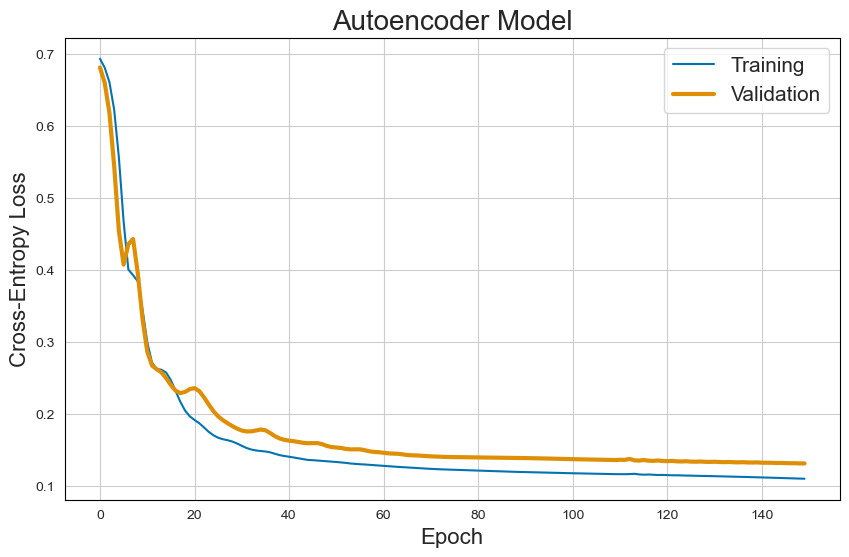

In [76]:
sns.set_palette("colorblind")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})

# plot training loss and validation loss 
figure = plt.figure(figsize = [10, 6])
plt.plot(np.arange(len(train_loss[:])), train_loss[:], label='Training')
plt.plot(np.arange(len(val_loss[:])), val_loss[:], label='Validation', linewidth=3)
plt.ylabel('Cross-Entropy Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.title("Autoencoder Model", fontsize=20)
plt.legend(fontsize=15)
plt.savefig('autoencoder_loss.png')
plt.show() 


### (e) Test Model

In [64]:
# test data from u1.test
ratings_test = pd.read_csv("Data/ml-100k/u1.test", sep="\t", names=sel_cols, encoding="latin-1")
print(ratings_test.shape)
test_data = user_item_matrix(ratings_test, items).to(device)
test_predicted = model(test_data) # reconstruct users' preferences through the model
test_loss = loss_function(test_predicted, test_data).item() # between 0 and 1, with 0 being a perfect model
print("The cross entropy loss obtained from test data is {:.6}".format(test_loss))

(20000, 4)
The cross entropy loss obtained from test data is 0.087586


The autoencoer model is trained to make output (predicted values) as close as possible to the desired output (truth values). The model output ranges from 0 to 1, indicating the probability that a user will watch a movie. 


To map the output into a binary class, we need to set a thresholod which governs the choice to turn a the probability into a class label. The decision threshold used here is 0.5 to interpret probabilities to class 0 or 1. If the predicted probability is greater than 0.5, it is classified as 1, otherwise it is classified as 0.

Use precision and recall (metrics used to measure the performance of a classifier) to evaluate the autoencoder model.

* Precision is defined as the number of true positives (tp) over the number of true positives (tp) plus the number of false positives (fp). Precision measures the proportion of recommended items that are actually relevant and is directly related to our business objective.

* Recall is defined as the number of true positives (tp) over the number of true positives (tp) plus the number of false negatives (fn). The recall is intuitively the ability of the classifier to find all the positive samples. Recall indicates the proportion of relevant items that are in the recommended list.

In [65]:
# calculate precision and recall of every user
precision = []
recall = []
data_all = user_item_matrix(ratings_all, items)
for user in range(data_all.shape[0]):
    user_targets = data_all[user].to(device)
    # here, a threshold of 0.5 is used to divide output into 0 or 1 classes
    user_predictions = torch.round(model(user_targets)) 
    user_predictions = user_predictions.cpu().detach().numpy()
    user_targets = user_targets.cpu().detach().numpy()
    precision.append(precision_score(user_targets, user_predictions, zero_division=1))
    recall.append(recall_score(user_targets, user_predictions))

print("The average precision across all users is {:.4f}.".format(np.mean(precision)))
print("The average recall across all users is {:.4f}.".format(np.mean(recall)))

The average precision across all users is 0.7173.
The average recall across all users is 0.2219.


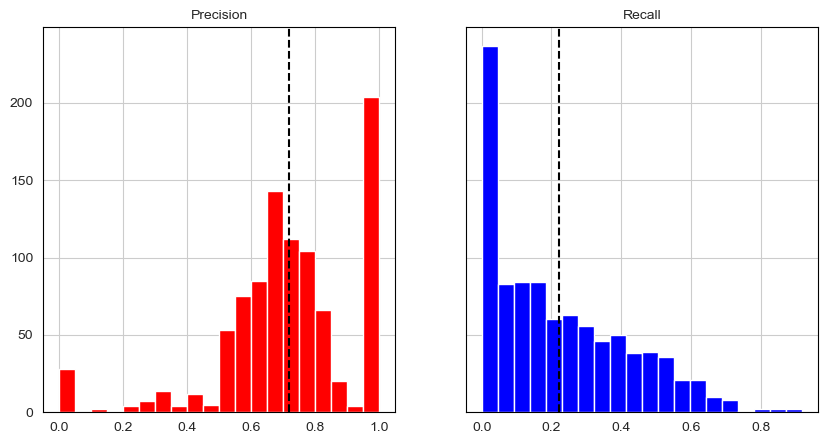

In [66]:
figure, axs = plt.subplots(1,2, sharex='col', sharey='row', figsize=(10, 5))
axs[0].hist(precision, color='r', bins=20)
axs[0].axvline(x=np.mean(precision), c='black', ls="--")
axs[0].set_title("Precision", fontsize='medium')
axs[1].hist(recall, color='b', bins=20)
axs[1].axvline(x=np.mean(recall), c='black', ls="--")
axs[1].set_title("Recall", fontsize='medium')
plt.show()

### (f) Make Movie Recommendations

Recommend the top-10 best NEW movies for every user based on the preference reconstructed by the model. The NEW movies here refer to movies a user hasn't watched.
* Find out movies that a user hasn't watched
* Sort the model predictions in descending order and get the top 10

In [84]:
movies_recom = {"user_id": [], "movie_id": [], 'movie_title':[], "rating_pred": []}

for user in range(data_all.shape[0]):
    user_targets = data_all[user].to(device)
    user_predictions = model(user_targets).cpu().detach().numpy()
    user_targets = user_targets.cpu().detach().numpy()
    unwatched = np.multiply(user_targets==0, user_predictions) # find out unwatched movies with their predictions
    recommended = np.argsort(unwatched)[::-1][:10] # sort predictions and get the top 10
    user_rating = user_predictions[recommended]

    for rating, movie in zip(user_rating, recommended):
        movies_recom["user_id"].append(user+1) # user_id = index + 1 according to user_item_matrix()
        movies_recom["movie_id"].append(movie) 
        movies_recom["movie_title"].append(items.loc[items['movie_id'] == movie+1]['movie_title'].tolist()[0]) # movie_id = index + 1 according to user_item_matrix()
        movies_recom["rating_pred"].append(rating)
        
     
movies_recom = pd.DataFrame(movies_recom)
movies_recom.to_csv("Recommendation Results/recommended_movies.txt", index=False)

print("The top-10 best NEW movies recommended to the first user:")
movies_recom.head(10)

The top-10 best NEW movies recommended to the first user:


,user_id,movie_id,movie_title,rating_pred
0,1,404,Mission: Impossible (1996),0.840511
1,1,422,E.T. the Extra-Terrestrial (1982),0.820940
2,1,384,True Lies (1994),0.755836
3,1,567,Speed (1994),0.742392
4,1,545,Broken Arrow (1996),0.707413
5,1,402,Batman (1989),0.678871
6,1,366,Clueless (1995),0.668119
7,1,287,Scream (1996),0.667466
8,1,654,Stand by Me (1986),0.655359
9,1,317,Schindler's List (1993),0.651407


In [93]:
import pickle
train_output = "Processed Data/train_data.pickle"
with open(train_output, 'wb') as f_p: # pickle the trained model, write as binary 
    pickle.dump(train_data, f_p, protocol=pickle.HIGHEST_PROTOCOL)

In [94]:
data_output = "Processed Data/data_all.pickle"
with open(data_output, 'wb') as f_p: # pickle the trained model, write as binary 
    pickle.dump(data_all, f_p, protocol=pickle.HIGHEST_PROTOCOL)